In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
plt.style.use('../figures/norm2.mplstyle')
from ldpc.code_util import *
from ldpc.mod2 import *
from bposd.hgp import hgp
from bposd.css import css_code, compute_code_distance
import sys, os

def read_pc(filepath):
    """
    Read parity check matrix from file.
    """
    with open(filepath, 'r') as f:
        lines = f.readlines()
    pc = []
    for line in lines:
        row = [int(x) for x in line.split()]
        pc.append(row)
    return np.array(pc, dtype=np.uint8)

readdir = '/Users/yitan/Google Drive/My Drive/from_cannon/qmemory_simulation/data/rgg_code'

In [2]:
sizes = np.array(range(10, 110, 10))
deg_bit = 4
deg_check = 5
ns = deg_check*sizes
ms = deg_bit*sizes
r = 0.2
seeds = np.array(range(0, 40))

In [3]:
def config_model_with_distance_bound(n, m, deg_bit, deg_check, r, rescale_factor=1, seed=0):
    G=nx.empty_graph(n+m)
    rng = np.random.default_rng(seed)
    if not n*deg_bit==m*deg_check:
        raise nx.NetworkXError(\
              'invalid degree sequences, n*deg_bit!=m*deg_check,%s,%s'\
              %(n*deg_bit,m*deg_check))

    pos = {i: rng.uniform(low=0, high=rescale_factor, size=2) for i in range(n+m)}
    G.add_nodes_from(range(0,n+m))
    'add bipartite attribute to nodes'
    b=dict(zip(range(0,n),[0]*n))
    shapes=dict(zip(range(0,n),['o']*n)) # circle
    b.update(dict(zip(range(n,n+m),[1]*m)))
    shapes.update(dict(zip(range(n,n+m),['s']*m))) # square
    nx.set_node_attributes(G,b,'bipartite') 
    'add position attribute to nodes'
    nx.set_node_attributes(G,pos,'pos')
    stubs = [[v]*deg_bit for v in range(0,n)]
    astubs = [x for subseq in stubs for x in subseq]
    stubs = [[v]*deg_check for v in range(n,n+m)]
    bstubs = [x for subseq in stubs for x in subseq]
    rng.shuffle(astubs)
    rng.shuffle(bstubs)
    edge_list = list(zip(astubs,bstubs))
    for u,v in edge_list:
        if np.linalg.norm(pos[u]-pos[v]) < r:
            G.add_edge(u,v)
    return G

def gen_rgg_code_rescaled(n, m, deg_bit, deg_check, r, seed):
    G = config_model_with_distance_bound(n, m, deg_bit=deg_bit, deg_check=deg_check, r=r, rescale_factor=np.sqrt(size/10) ,seed=seed)
    pc = nx.bipartite.biadjacency_matrix(G, row_order=range(n,n+m), column_order=range(n))
    pc = pc.toarray().astype(int)
    return G, pc

### Plot classical RGG code

In [ ]:
# Gs = [config_model_with_distance_bound(n, m, deg_bit=deg_bit, deg_check=deg_check, r=rs[i]) for i in range(4)]
# for i in range(4):
#     pc = nx.bipartite.biadjacency_matrix(Gs[i], row_order=range(n,n+m), column_order=range(n))
#     pc = pc.toarray().astype(int)
#     np.savetxt(f'../data/rgg_code/hclassical_n{n}_m{m}_degbit{deg_bit}_degcheck{deg_check}_r{rs[i]}_seed{seed}.txt', pc, fmt='%d')
#     row = i // 2
#     col = i % 2
#     G = Gs[i]
#     pos = nx.get_node_attributes(G, 'pos')
#     pos_nodes = [pos[i] for i in range(n)]
#     pos_checks = [pos[i] for i in range(n, n+m)]
#     for edge in G.edges():
#         u, v = edge
#         ax[row, col].plot(*zip(pos[u], pos[v]), color='k', linestyle='-', linewidth=0.5)
#     ax[row, col].scatter(*zip(*pos_nodes), color='r', marker='o')
#     ax[row, col].scatter(*zip(*pos_checks), color='b', marker='s')
# plt.show()

[9 2 5 8]


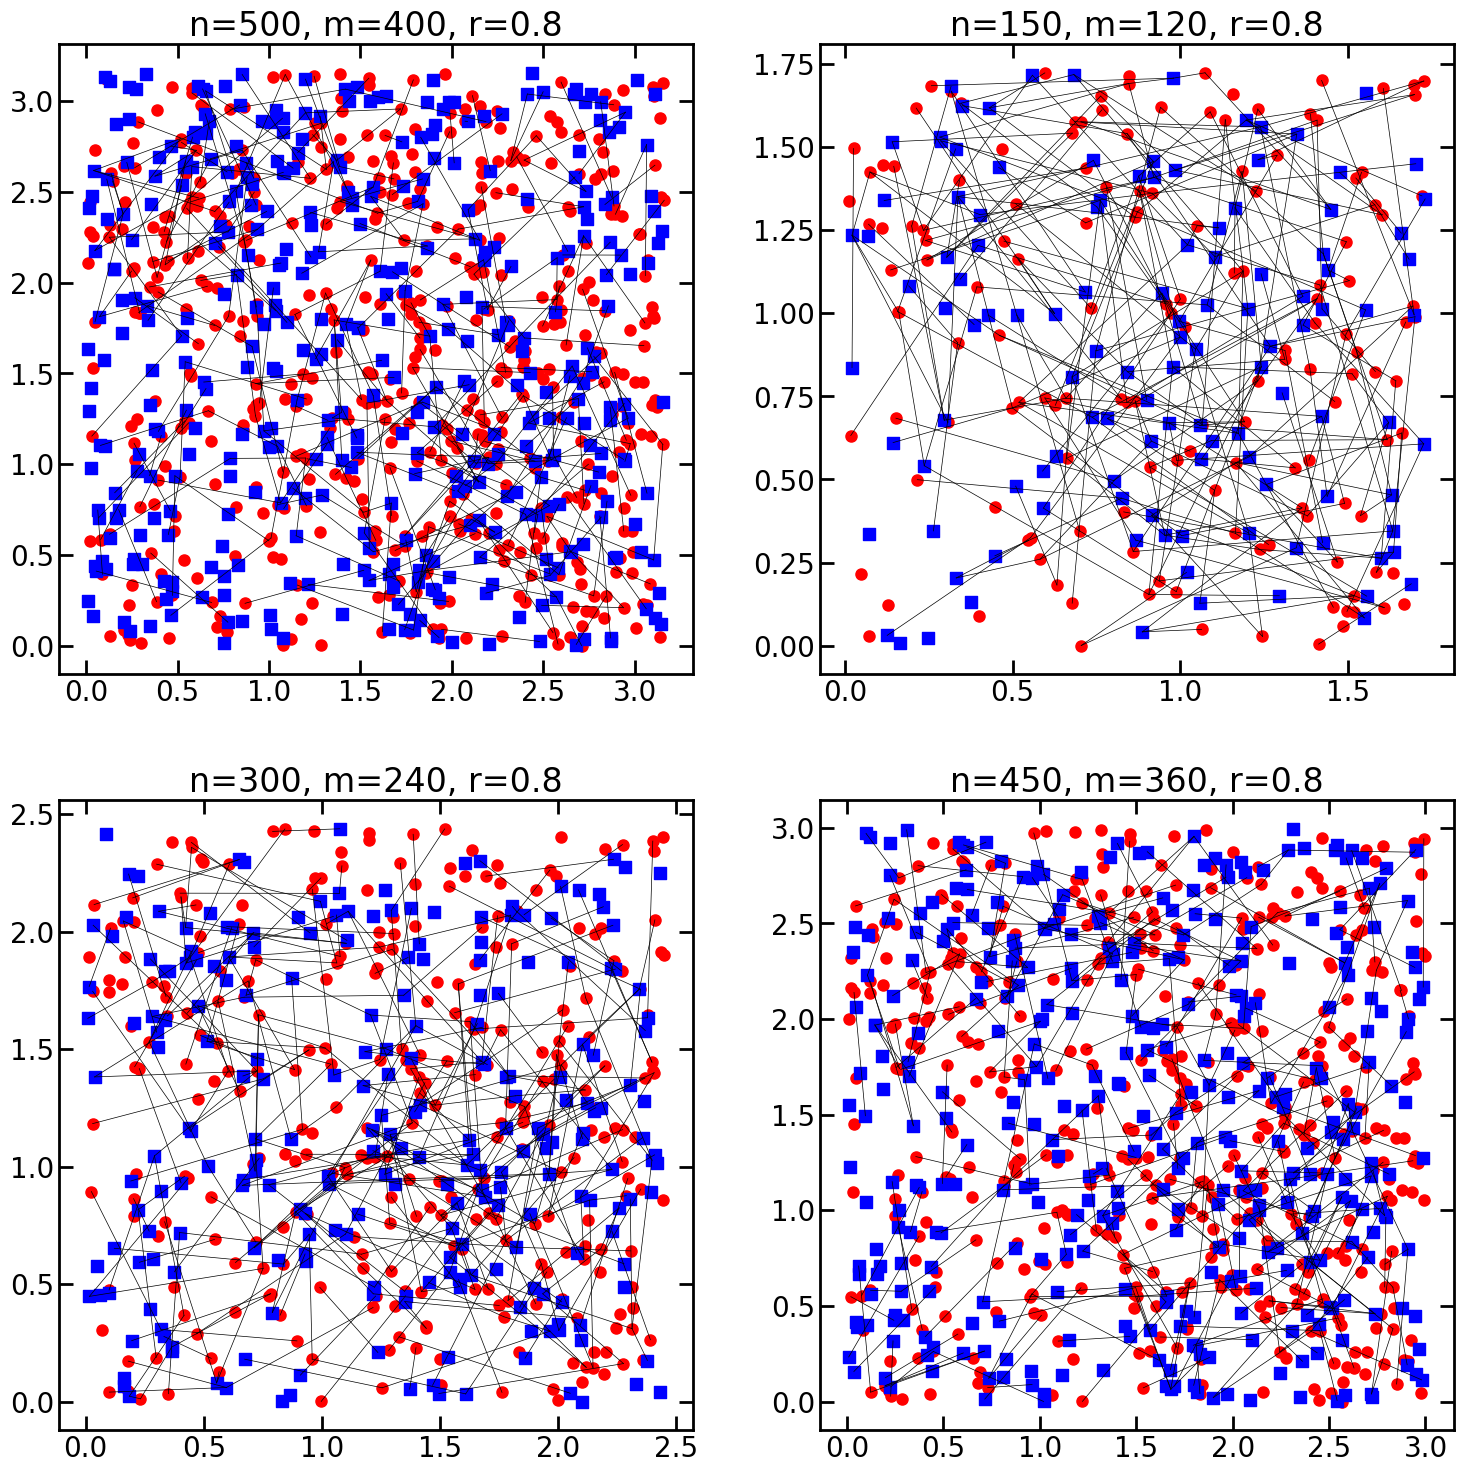

In [9]:
# rs = [0.2, 0.4, 0.6, 0.8]
r = 0.8
selected_size = np.random.choice(range(len(sizes)), size=4, replace=False)
print(selected_size)
fig, ax = plt.subplots(2, 2)
for row in range(2):
    for col in range(2):
        idx = 2*row + col
        G = config_model_with_distance_bound(n=ns[selected_size[idx]], m=ms[selected_size[idx]], deg_bit=deg_bit, deg_check=deg_check, r=r, rescale_factor=np.sqrt(sizes[selected_size[idx]]/10), seed=seeds[0])
        pos = nx.get_node_attributes(G, 'pos')
        pos_nodes = [pos[i] for i in range(ns[selected_size[idx]])]
        pos_checks = [pos[i] for i in range(ns[selected_size[idx]], ns[selected_size[idx]]+ms[selected_size[idx]])]
        for edge in G.edges():
            u, v = edge
            ax[row, col].plot(*zip(pos[u], pos[v]), color='k', linestyle='-', linewidth=0.5)
        ax[row, col].scatter(*zip(*pos_nodes), color='r', marker='o')
        ax[row, col].scatter(*zip(*pos_checks), color='b', marker='s')
        ax[row, col].set_title(f'n={ns[selected_size[idx]]}, m={ms[selected_size[idx]]}, r={r}')
fig.set_size_inches(18, 18)
fig.savefig('../figures/local_classical_ldpc_illustration.pdf')
plt.show()

### Kernel and coimage scaling

In [63]:
rs = [0.2, 0.4, 0.6, 0.8]
dimkers = {}
dimcoimgs = {}
avg_dimkers = {}
avg_dimcoimgs = {}
for ir, r in enumerate(rs):
    dimkers[f'r{r}'] = []
    dimcoimgs[f'r{r}'] = []
    avg_dimkers[f'r{r}'] = []
    avg_dimcoimgs[f'r{r}'] = []
    for isize, size in enumerate(sizes):
        dimkers[f'r{r}'].append([])
        dimcoimgs[f'r{r}'].append([])
        for iseed, seed in enumerate(seeds):
            readpath = os.path.join(readdir, f'hclassical_n{ns[isize]}_m{ms[isize]}_degbit{deg_bit}_degcheck{deg_check}_r{r}_seed{seed}.txt')
            h = read_pc(readpath)
            dimkers[f'r{r}'][-1].append(len(nullspace(h)))
            dimcoimgs[f'r{r}'][-1].append(ms[isize] - len(row_basis(h)))
        avg_dimkers[f'r{r}'].append(np.mean(dimkers[f'r{r}'][-1]))
        avg_dimcoimgs[f'r{r}'].append(np.mean(dimcoimgs[f'r{r}'][-1]))

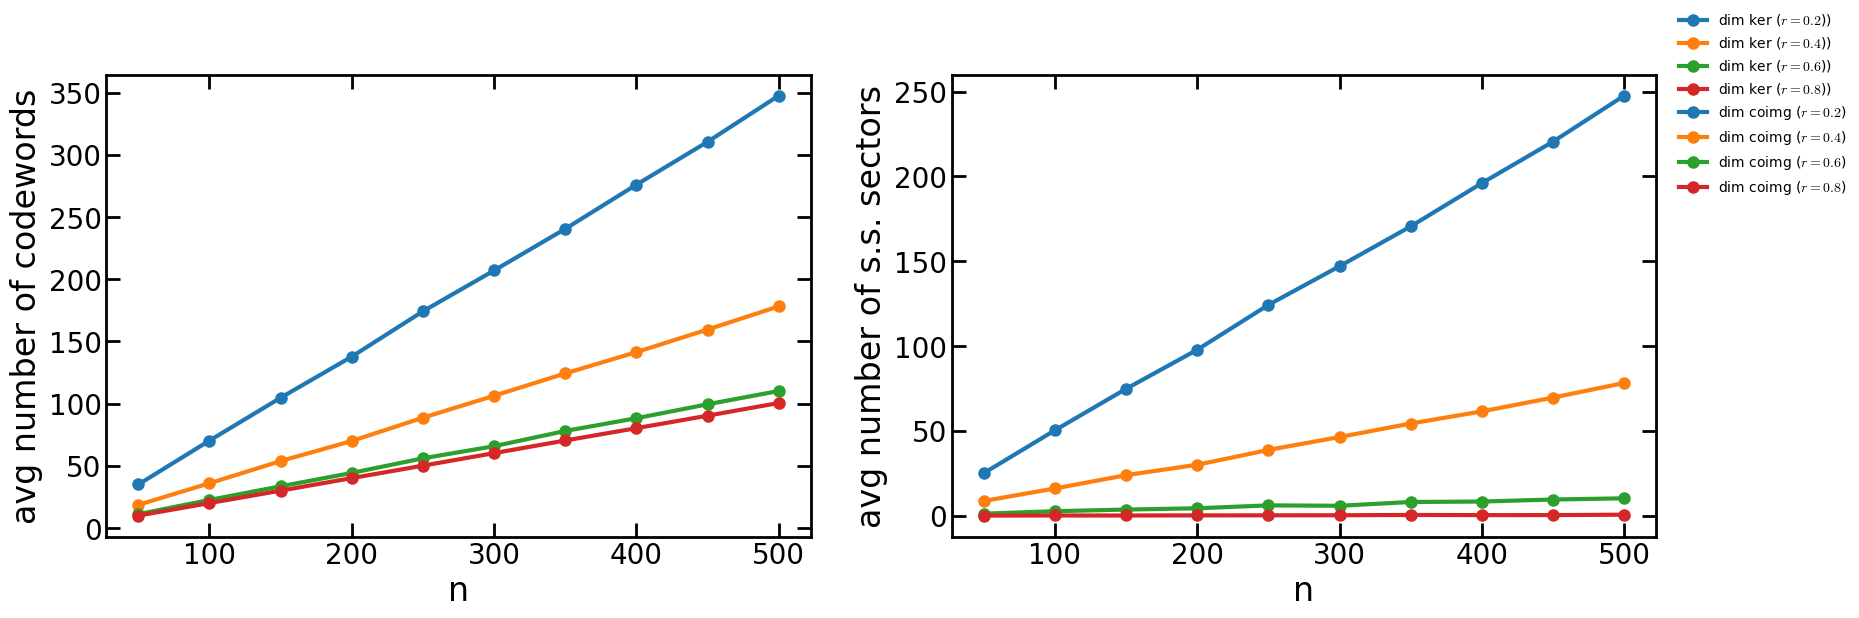

In [68]:
fig, ax = plt.subplots(1, 2)
ax[0].plot(ns, avg_dimkers['r0.2'], 'o-', label='dim ker ($r=0.2$))')
ax[0].plot(ns, avg_dimkers['r0.4'], 'o-', label='dim ker ($r=0.4$))')
ax[0].plot(ns, avg_dimkers['r0.6'], 'o-', label='dim ker ($r=0.6$))')
ax[0].plot(ns, avg_dimkers['r0.8'], 'o-', label='dim ker ($r=0.8$))')
ax[0].set_xlabel('n')
ax[0].set_ylabel('avg number of codewords')
# ax[0].set_title('avg dim ker vs n')
ax[1].plot(ns, avg_dimcoimgs['r0.2'], 'o-', label='dim coimg ($r=0.2$)')
ax[1].plot(ns, avg_dimcoimgs['r0.4'], 'o-', label='dim coimg ($r=0.4$)')
ax[1].plot(ns, avg_dimcoimgs['r0.6'], 'o-', label='dim coimg ($r=0.6$)')
ax[1].plot(ns, avg_dimcoimgs['r0.8'], 'o-', label='dim coimg ($r=0.8$)')
ax[1].set_xlabel('n')
ax[1].set_ylabel('avg number of s.s. sectors')
# ax[1].set_title('avg number of superselection sectors vs n')
fig.legend()
fig.set_size_inches(20, 6)
fig.savefig('../figures/rgg_code_dim_scaling.pdf')
plt.show()

### Minimum distance scaling
[reference](https://digital.library.unt.edu/ark:/67531/metadc743246/m2/1/high_res_d/794005.pdf)

#### Before rescaling

In [19]:
min_dists = []
avg_min_dists = []
for i, size in enumerate(sizes):
    min_dists.append([])
    for j, seed in enumerate(seeds):
        readpath = os.path.join(readdir, f'mindist_n{ns[i]}_m{ms[i]}_degbit{deg_bit}_degcheck{deg_check}_r{r}_seed{seed}.npy')
        min_dist = np.load(readpath)
        min_dists[-1].append(min_dist)
    avg_min_dists.append(np.mean(min_dists[-1]))

In [20]:
def inverse_sqrt(x, a):
    return a/np.sqrt(x)

from scipy.optimize import curve_fit
popt, pcov = curve_fit(inverse_sqrt, ns, avg_min_dists)

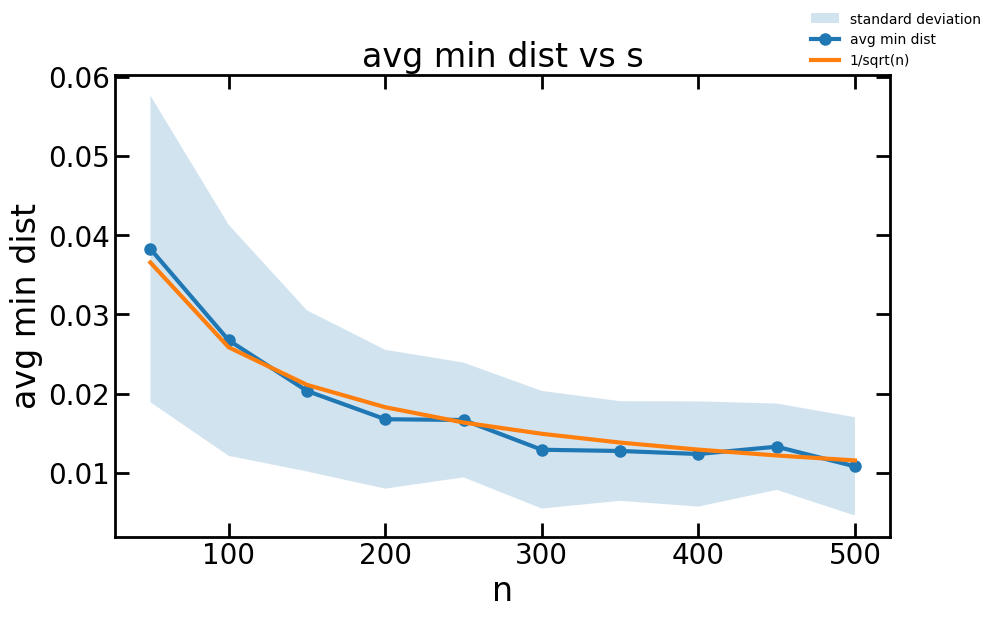

In [74]:
# fig, ax = plt.subplots(1, 1)
# ax.fill_between(ns, avg_min_dists-np.std(min_dists, axis=1), avg_min_dists+np.std(min_dists, axis=1), alpha=0.2, label='standard deviation')
# ax.plot(ns, avg_min_dists, 'o-', label='avg min dist')
# ax.plot(ns, popt/np.sqrt(ns), label='1/sqrt(n)')
# ax.set_xlabel('n')
# ax.set_ylabel('avg min dist')
# ax.set_title('avg min dist vs s')
# fig.legend()
# fig.set_size_inches(10, 6)
# fig.savefig('../figures/rgg_avg_min_dist.pdf')
# plt.show()

#### After rescaling

In [21]:
min_dists_rescaled = []
avg_min_dists_rescaled = []
for i, size in enumerate(sizes):
    min_dists_rescaled.append([])
    for j, seed in enumerate(seeds):
        readpath = os.path.join(readdir, f'mindist_rescaled_n{ns[i]}_m{ms[i]}_degbit{deg_bit}_degcheck{deg_check}_r{r}_seed{seed}.npy')
        min_dist = np.load(readpath)
        min_dists_rescaled[-1].append(min_dist)
    avg_min_dists_rescaled.append(np.mean(min_dists[-1]))

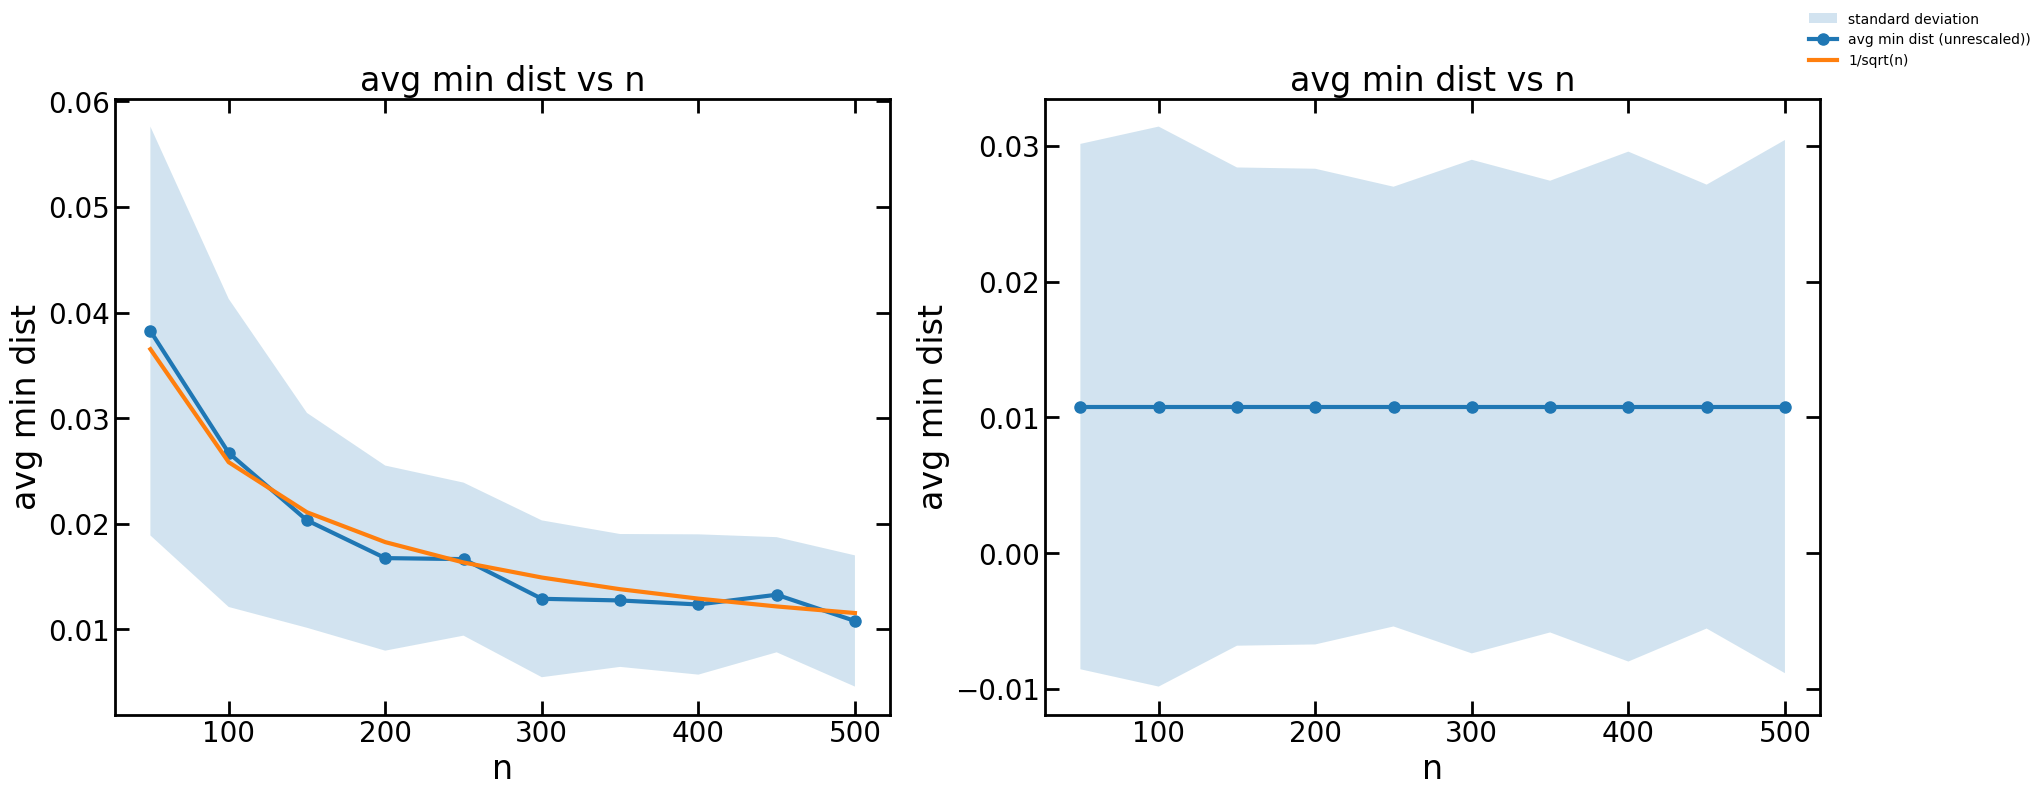

In [34]:
fig, ax = plt.subplots(1, 2)
# left plot: unrescaled
ax[0].fill_between(ns, avg_min_dists-np.std(min_dists, axis=1), avg_min_dists+np.std(min_dists, axis=1), alpha=0.2, label='standard deviation')
ax[0].plot(ns, avg_min_dists, 'o-', label='avg min dist')
ax[0].plot(ns, popt/np.sqrt(ns), label='1/sqrt(n)')
ax[0].set_xlabel('n')
ax[0].set_ylabel('avg min dist (unrescaled)')
ax[0].set_title('unrescaled')
# right plot: rescaled
ax[1].fill_between(ns, avg_min_dists_rescaled-np.std(min_dists_rescaled, axis=1), avg_min_dists_rescaled+np.std(min_dists_rescaled, axis=1), alpha=0.2)
ax[1].plot(ns, avg_min_dists_rescaled, 'o-')
ax[1].set_xlabel('n')
ax[1].set_ylabel('avg min dist (rescaled))')
ax[1].set_title('rescaled')
fig.legend()
fig.set_size_inches(22, 8)
fig.savefig('../figures/rgg_avg_min_dist.pdf')
plt.show()

### Scaling of hypergraph product codes (BPT bound)

In [ ]:
r = 0.2
seed1 = 0
seed2 = 20
dimkers = {'r0.2': []}
dimcoimgs = {'r0.2': []}
avg_dimkers = {'r0.2': []}
avg_dimcoimgs = {'r0.2', []}
for isize, size in enumerate(sizes):
    readpath1 = os.path.join(readdir, f'hclassical_n{ns[isize]}_m{ms[isize]}_degbit{deg_bit}_degcheck{deg_check}_r{r}_seed{seed1}.txt')
    h1 = read_pc(readpath1)
    readpath2 = os.path.join(readdir, f'hclassical_n{ns[isize]}_m{ms[isize]}_degbit{deg_bit}_degcheck{deg_check}_r{r}_seed{seed2}.txt')
    h2 = read_pc(readpath2)
    qcode = hgp(h1=h1, h2=h2)
    dimkers['r0.2'].append(qcode.K)
    # dimcoimgs['r0.2'].append(qcode.M - qcode.K)
    dimcoimgs['r0.2'].append(compute_code_distance(h1, h2))
